In [ ]:
!pip install prophet --quiet

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from prophet import Prophet
import plotly.express as px
import re

In [8]:
file_path = '/content/drive/MyDrive/Flight/flight_fares_cleaned.csv'

In [9]:
bus_path = '/content/drive/MyDrive/Flight/business.csv'
eco_path = '/content/drive/MyDrive/Flight/economy.csv'

In [10]:
business_df = pd.read_csv(bus_path)
economy_df = pd.read_csv(eco_path)

### Preprocessing and Merging into a single dataframe.

In [11]:
# Add a 'Class' column to distinguish between business and economy flights
business_df['Class'] = 'Business'
economy_df['Class'] = 'Economy'

# Merge the two dataframes
merged_df = pd.concat([business_df, economy_df], ignore_index=True)


# --- Data Cleaning and Preprocessing ---

# 1. Date and Time Columns

# Convert 'date' to datetime objects
merged_df['date'] = pd.to_datetime(merged_df['date'], format='%d-%m-%Y')

# Convert 'dep_time' and 'arr_time' to datetime objects (time only)
merged_df['dep_time'] = pd.to_datetime(merged_df['dep_time'], format='%H:%M').dt.time
merged_df['arr_time'] = pd.to_datetime(merged_df['arr_time'], format='%H:%M').dt.time


# 2. `time_taken` Column
# Convert 'time_taken' to total minutes (numeric)
def convert_time_taken_to_minutes(time_str):
    if pd.isna(time_str):
        return None
    time_str = str(time_str).strip()

    # Handle cases like '1.03' if they represent hours (e.g., 1.03 hours)
    if re.match(r'^\d+\.\d+$', time_str):
        try:
            return int(float(time_str) * 60) # Assuming it's in hours, convert to int
        except ValueError:
            pass # Fall through to other patterns if conversion fails

    # Pattern for 'HHh MMm' or 'HHh' or 'MMm'
    match = re.match(r'(?:(\d+)h\s*)?(?:(\d+)m)?', time_str)
    if match:
        hours = int(match.group(1)) if match.group(1) else 0
        minutes = int(match.group(2)) if match.group(2) else 0
        return hours * 60 + minutes
    return None # Return None for unparseable formats

merged_df['time_taken_minutes'] = merged_df['time_taken'].apply(convert_time_taken_to_minutes)
merged_df.drop('time_taken', axis=1, inplace=True) # Drop original column


# 3. `stop` Column
# Clean and standardize 'stop' column
merged_df['stop'] = merged_df['stop'].str.replace(r'\n\t\t\t\t\t\t\t\t\t\t\t\t', '', regex=True).str.strip()

# New logic for `num_stops` column as requested by the user
def convert_stop_to_numeric_v2(stop_str):
    if pd.isna(stop_str):
        return None
    stop_str = str(stop_str).lower().strip()

    if stop_str == 'non-stop':
        return 0
    # Use regex to find any number followed by '-stop' or 'plus-stop'
    match = re.match(r'(\d+)-stop', stop_str)
    if match:
        return int(match.group(1))
    elif stop_str == '2+-stop': # Specific case for 2+
        return 2
    return None # For any other unexpected formats

merged_df['num_stops'] = merged_df['stop'].apply(convert_stop_to_numeric_v2)

# Drop the original 'stop' column
merged_df.drop('stop', axis=1, inplace=True)


# 4. `from` and `to` (City Names) Columns
# Standardize city names (e.g., title case, remove extra spaces)
merged_df['from'] = merged_df['from'].str.title().str.strip()
merged_df['to'] = merged_df['to'].str.title().str.strip()


# 5. `airline` (Flight Company) Column
# Standardize airline names (e.g., title case, remove extra spaces)
merged_df['airline'] = merged_df['airline'].str.title().str.strip()


# 6. `price` Column
# Convert 'price' to numeric by removing commas
merged_df['price'] = merged_df['price'].str.replace(',', '').astype(float)


# 7. `ch_code` and `num_code` (Code) Columns
# For `ch_code`, just standardize to uppercase and strip spaces
merged_df['ch_code'] = merged_df['ch_code'].str.upper().str.strip()

# Save the cleaned DataFrame to a new CSV file
merged_df.to_csv('cleaned_flights_data_final.csv', index=False)

## Start EDA

In [12]:
df = pd.read_csv('/content/drive/MyDrive/Flight/cleaned_flights_data_final.csv')
df.head()

,date,airline,ch_code,num_code,dep_time,from,arr_time,to,price,Class,time_taken_minutes,num_stops
0,2022-02-11,Air India,AI,868,18:00:00,Delhi,20:00:00,Mumbai,25612.0,Business,120,0
1,2022-02-11,Air India,AI,624,19:00:00,Delhi,21:15:00,Mumbai,25612.0,Business,135,0
2,2022-02-11,Air India,AI,531,20:00:00,Delhi,20:45:00,Mumbai,42220.0,Business,1485,1
3,2022-02-11,Air India,AI,839,21:25:00,Delhi,23:55:00,Mumbai,44450.0,Business,1590,1
4,2022-02-11,Air India,AI,544,17:15:00,Delhi,23:55:00,Mumbai,46690.0,Business,400,1


In [14]:
df['date'] = pd.to_datetime(df['date'])
# Create route column
df['route'] = df['from'] + " → " + df['to']
df.head()

,date,airline,ch_code,num_code,dep_time,from,arr_time,to,price,Class,time_taken_minutes,num_stops,route
0,2022-02-11,Air India,AI,868,18:00:00,Delhi,20:00:00,Mumbai,25612.0,Business,120,0,Delhi → Mumbai
1,2022-02-11,Air India,AI,624,19:00:00,Delhi,21:15:00,Mumbai,25612.0,Business,135,0,Delhi → Mumbai
2,2022-02-11,Air India,AI,531,20:00:00,Delhi,20:45:00,Mumbai,42220.0,Business,1485,1,Delhi → Mumbai
3,2022-02-11,Air India,AI,839,21:25:00,Delhi,23:55:00,Mumbai,44450.0,Business,1590,1,Delhi → Mumbai
4,2022-02-11,Air India,AI,544,17:15:00,Delhi,23:55:00,Mumbai,46690.0,Business,400,1,Delhi → Mumbai


In [15]:
print("Shape of dataset:", df.shape)
print("\nMissing values:\n", df.isnull().sum())
print("\nData Types:\n", df.dtypes)

# Descriptive statistics
df.describe(include='all')

Shape of dataset: (300261, 13)

Missing values:
 date                  0
airline               0
ch_code               0
num_code              0
dep_time              0
from                  0
arr_time              0
to                    0
price                 0
Class                 0
time_taken_minutes    0
num_stops             0
route                 0
dtype: int64

Data Types:
 date                  datetime64[ns]
airline                       object
ch_code                       object
num_code                       int64
dep_time                      object
from                          object
arr_time                      object
to                            object
price                        float64
Class                         object
time_taken_minutes             int64
num_stops                      int64
route                         object
dtype: object


,date,airline,ch_code,num_code,dep_time,from,arr_time,to,price,Class,time_taken_minutes,num_stops,route
count,300261,300261,300261,300261.000000,300261,300261,300261,300261,300261.000000,300261,300261.000000,300261.000000,300261
unique,NaN,8,8,NaN,251,6,266,6,NaN,2,NaN,NaN,30
top,NaN,Vistara,UK,NaN,07:00:00,Delhi,19:55:00,Mumbai,NaN,Economy,NaN,NaN,Delhi → Mumbai
freq,NaN,127859,127859,NaN,8760,61345,9194,59109,NaN,206774,NaN,NaN,15291
mean,2022-03-08 00:06:26.447790336,NaN,NaN,1417.771709,NaN,NaN,NaN,NaN,20883.717666,NaN,733.064617,0.924213,NaN
min,2022-02-11 00:00:00,NaN,NaN,101.000000,NaN,NaN,NaN,NaN,1105.000000,NaN,0.000000,0.000000,NaN
25%,2022-02-25 00:00:00,NaN,NaN,637.000000,NaN,NaN,NaN,NaN,4783.000000,NaN,405.000000,1.000000,NaN
50%,2022-03-08 00:00:00,NaN,NaN,818.000000,NaN,NaN,NaN,NaN,7425.000000,NaN,675.000000,1.000000,NaN
75%,2022-03-20 00:00:00,NaN,NaN,927.000000,NaN,NaN,NaN,NaN,42521.000000,NaN,970.000000,1.000000,NaN
max,2022-03-31 00:00:00,NaN,NaN,9991.000000,NaN,NaN,NaN,NaN,123071.000000,NaN,2990.000000,2.000000,NaN


## Aveage Prices as per the class

      Class         price
0  Business  52540.081124
1   Economy   6571.190701


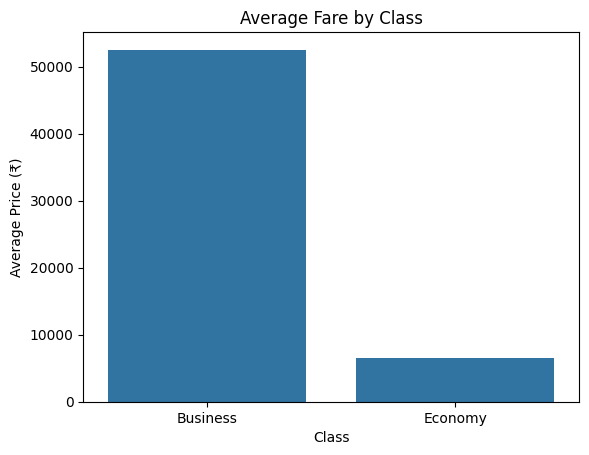

In [17]:
avg_price_class = df.groupby('Class')['price'].mean().reset_index()
print(avg_price_class)

# Bar plot
sns.barplot(data=avg_price_class, x='Class', y='price')
plt.title("Average Fare by Class")
plt.ylabel("Average Price (₹)")
plt.show()

## Average Prices as per the airlines

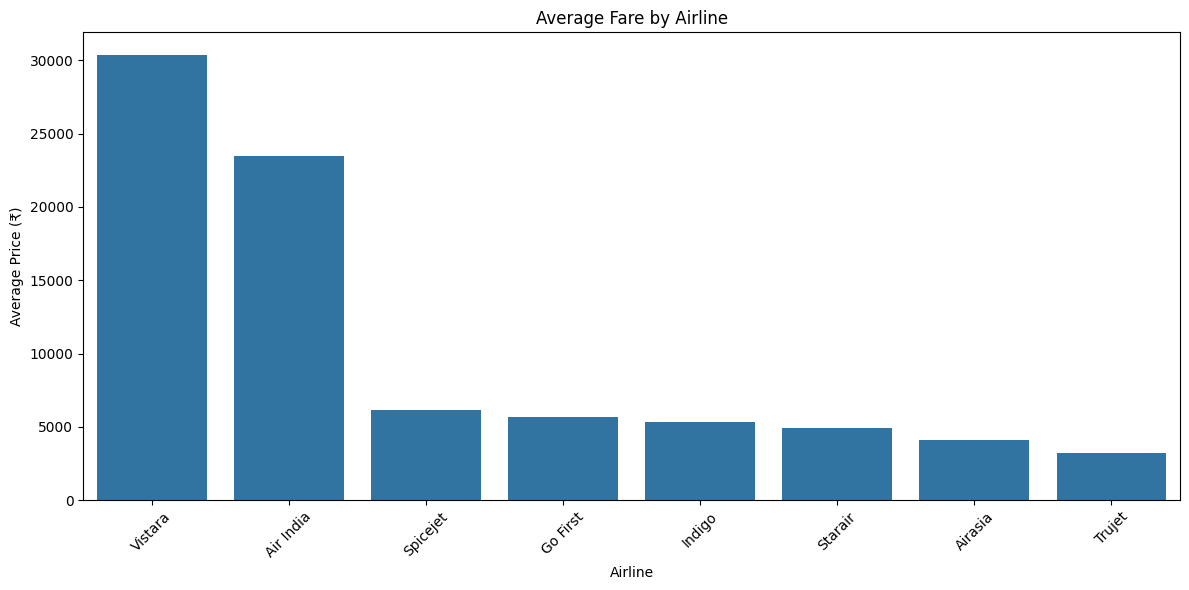

In [18]:
avg_price_airline = df.groupby('airline')['price'].mean().sort_values(ascending=False)

plt.figure(figsize=(12,6))
sns.barplot(x=avg_price_airline.index, y=avg_price_airline.values)
plt.xticks(rotation=45)
plt.title("Average Fare by Airline")
plt.ylabel("Average Price (₹)")
plt.xlabel("Airline")
plt.tight_layout()
plt.show()

## Prize distribution by class

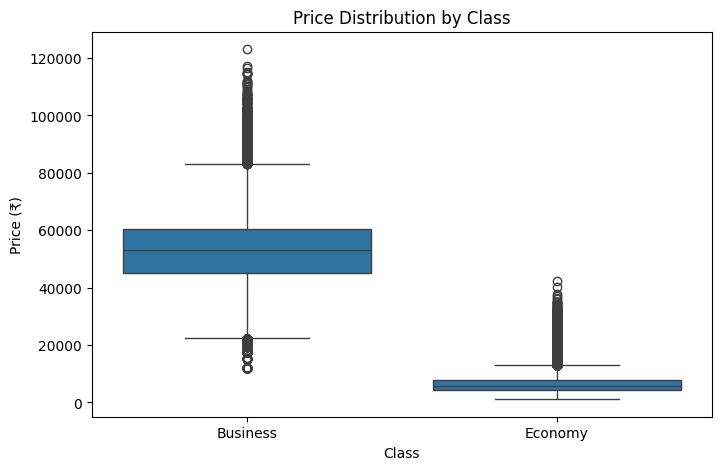

In [19]:
plt.figure(figsize=(8,5))
sns.boxplot(data=df, x='Class', y='price')
plt.title("Price Distribution by Class")
plt.ylabel("Price (₹)")
plt.show()

## Price vs Number of Stops

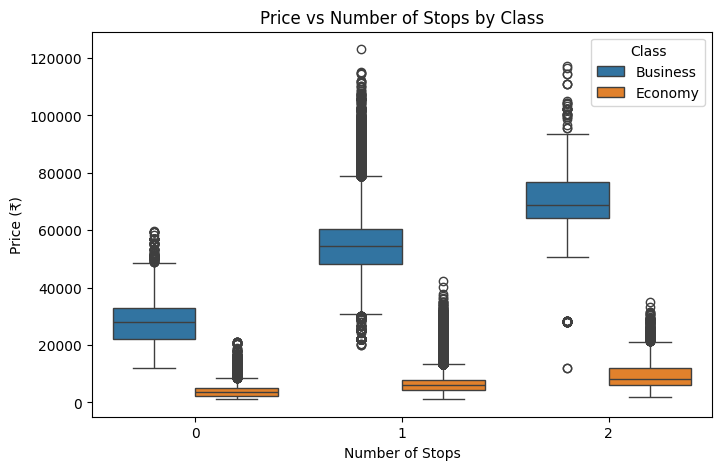

In [20]:
plt.figure(figsize=(8,5))
sns.boxplot(data=df, x='num_stops', y='price', hue='Class')
plt.title("Price vs Number of Stops by Class")
plt.xlabel("Number of Stops")
plt.ylabel("Price (₹)")
plt.show()

## Popular Routes by Frequency

In [21]:
route_counts = df['route'].value_counts().reset_index()
route_counts.columns = ['Route', 'Flight Count']

fig = px.bar(route_counts.head(10), x='Route', y='Flight Count',
             title="Top 10 Most Frequent Routes")
fig.show()

## Fare Trends over time (global)

In [22]:
daily_avg = df.groupby('date')['price'].mean().reset_index()

fig = px.line(daily_avg, x='date', y='price', title='Average Fare Over Time (All Routes)')
fig.show()

## Fare trend by route + class

In [23]:
# Example: Economy Class, Delhi → Mumbai
selected_route = 'Delhi → Mumbai'
selected_class = 'Economy'

route_df = df[(df['route'] == selected_route) & (df['Class'] == selected_class)]
route_trend = route_df.groupby('date')['price'].mean().reset_index()

fig = px.line(route_trend, x='date', y='price',
              title=f"{selected_class} Fare Trend for {selected_route}")
fig.show()

## Day of week analysis

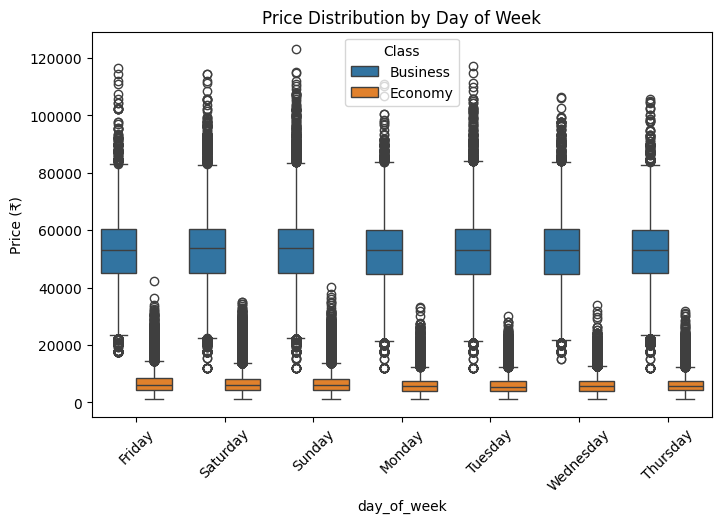

In [24]:
df['day_of_week'] = df['date'].dt.day_name()

plt.figure(figsize=(8,5))
sns.boxplot(data=df, x='day_of_week', y='price', hue='Class')
plt.title("Price Distribution by Day of Week")
plt.xticks(rotation=45)
plt.ylabel("Price (₹)")
plt.show()

## Correlation heatmap

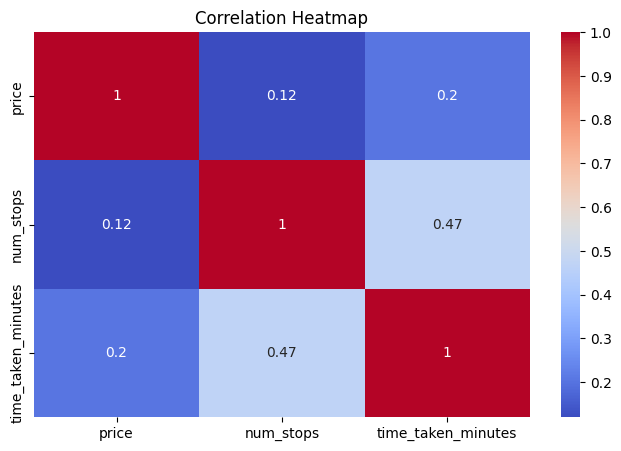

In [25]:
plt.figure(figsize=(8,5))
sns.heatmap(df[['price', 'num_stops', 'time_taken_minutes']].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

## Forecasting

In [26]:
!pip install prophet --quiet

In [27]:
from prophet import Prophet
import joblib

In [28]:
# Load your cleaned data
df = pd.read_csv('/content/drive/MyDrive/Flight/cleaned_flights_data_final.csv')
df['date'] = pd.to_datetime(df['date'])
df['route'] = df['from'] + " → " + df['to']

# Select route and class
selected_route = 'Delhi → Mumbai'
selected_class = 'Economy'

route_df = df[(df['route'] == selected_route) & (df['Class'] == selected_class)]


In [29]:
daily_avg = route_df.groupby('date')['price'].mean().reset_index()
daily_avg.columns = ['ds', 'y']

daily_avg.head()

,ds,y
0,2022-02-11,13425.686441
1,2022-02-12,12118.398496
2,2022-02-13,13273.489796
3,2022-02-14,10257.578313
4,2022-02-15,9952.857143


In [31]:
# Training model
model = Prophet()
model.fit(daily_avg)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpwnmq98b0/pnq1o2mx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpwnmq98b0/56il2oon.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=9978', 'data', 'file=/tmp/tmpwnmq98b0/pnq1o2mx.json', 'init=/tmp/tmpwnmq98b0/56il2oon.json', 'output', 'file=/tmp/tmpwnmq98b0/prophet_modele2tc_jtc/prophet_model-20250706130607.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:06:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:06:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [32]:
# Forecasting for the next 30 days
future = model.make_future_dataframe(periods=30)
forecast = model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
74,2022-04-26,3633.495658,1869.414000,5205.257492
75,2022-04-27,3823.765343,2012.044392,5462.968971
76,2022-04-28,3936.074114,2053.142893,5672.660058
77,2022-04-29,3778.507530,1706.886281,5550.760169
78,2022-04-30,3904.783835,1901.638413,5791.937904


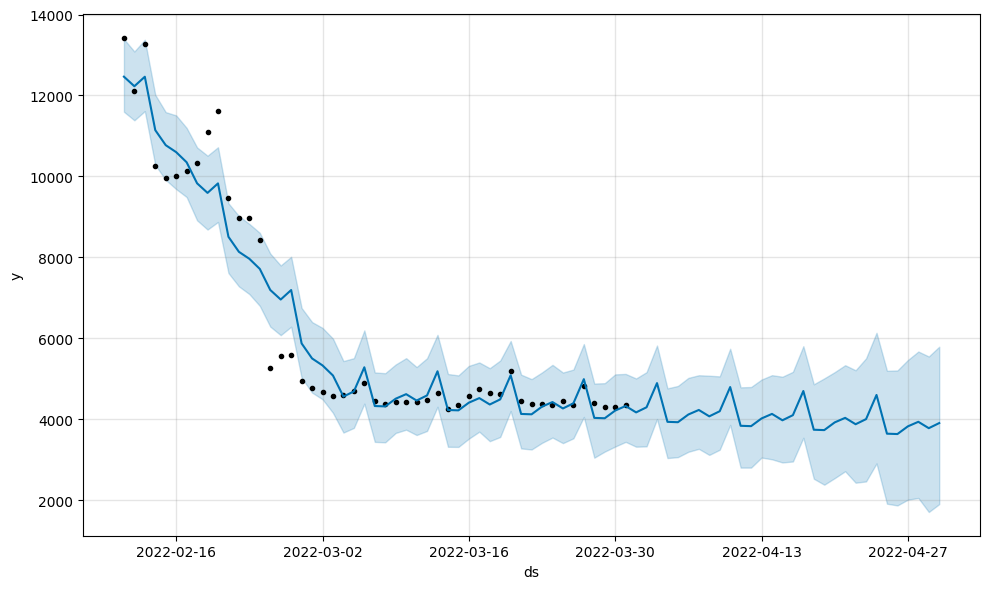

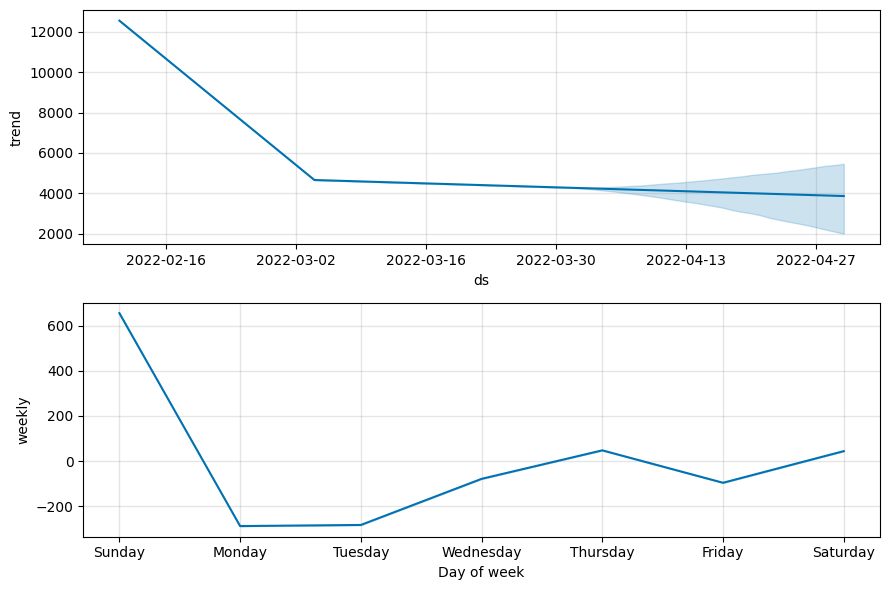

In [33]:
# Plot forecast
fig1 = model.plot(forecast)
fig2 = model.plot_components(forecast)

## Save forecast and model

In [37]:
import os

os.makedirs("/content/drive/MyDrive/Flight/models/", exist_ok=True)
os.makedirs("/content/drive/MyDrive/Flight/prediction/", exist_ok=True)

In [38]:
# Save forecast for future visualization
forecast.to_csv("/content/drive/MyDrive/Flight/prediction/forecast_delhi_mumbai_economy.csv", index=False)

# Save model as pickle
joblib.dump(model, "/content/drive/MyDrive/Flight/models/prophet_delhi_mumbai_economy.pkl")

['/content/drive/MyDrive/Flight/models/prophet_delhi_mumbai_economy.pkl']

# For Any Route, standardized code:

In [39]:
import os
import pandas as pd
from prophet import Prophet
import joblib

In [40]:
def train_and_save_forecast(df, from_city, to_city, flight_class, save_dir="/content/drive/MyDrive/Flight"):
    """
    Trains a Prophet model for a specific route and class,
    forecasts the next 30 days, and saves model and forecast to Google Drive.

    Parameters:
    - df: cleaned flight DataFrame (must have 'from', 'to', 'Class', 'date', 'price')
    - from_city: departure city (string)
    - to_city: destination city (string)
    - flight_class: 'Economy' or 'Business'
    - save_dir: base directory in Google Drive
    """

    # Clean and standardize city names
    from_city = from_city.strip().title()
    to_city = to_city.strip().title()

    # Create route string
    route = f"{from_city} → {to_city}"

    # Filter data
    sub_df = df[(df['from'] == from_city) &
                (df['to'] == to_city) &
                (df['Class'] == flight_class)].copy()

    if sub_df.empty:
        print(f"❌ No data found for {route} [{flight_class}]. Skipping.")
        return

    # Prepare Prophet input
    sub_df['date'] = pd.to_datetime(sub_df['date'])
    daily_avg = sub_df.groupby('date')['price'].mean().reset_index()
    daily_avg.columns = ['ds', 'y']

    # Fit Prophet model
    model = Prophet()
    model.fit(daily_avg)

    # Forecast next 30 days
    future = model.make_future_dataframe(periods=30)
    forecast = model.predict(future)

    # Save paths
    safe_name = f"{from_city}_{to_city}".replace(" ", "_").lower()
    class_name = flight_class.lower()

    model_dir = os.path.join(save_dir, "models")
    data_dir = os.path.join(save_dir, "prediction")
    os.makedirs(model_dir, exist_ok=True)
    os.makedirs(data_dir, exist_ok=True)

    model_path = os.path.join(model_dir, f"prophet_{safe_name}_{class_name}.pkl")
    forecast_path = os.path.join(data_dir, f"forecast_{safe_name}_{class_name}.csv")

    # Save model and forecast
    joblib.dump(model, model_path)
    forecast.to_csv(forecast_path, index=False)

    print(f"✅ Model saved to: {model_path}")
    print(f"✅ Forecast saved to: {forecast_path}")


### Send data from here

In [ ]:
df = pd.read_csv(/content/drive/MyDrive/Flight/cleaned_flights_data_final.csv)

train_and_save_forecast(df, from_city="Kolkata", to_city="Mumbai", flight_class="Economy")
# train_and_save_forecast(df, from_city="Kolkata", to_city="Delhi", flight_class="Business")